# Sympy preamble

In [1]:
from IPython.display import Latex, display
from sympy import (Rational, exp, factor, integrate, lambdify, log, oo, pi,
                   sqrt, symbols)
from sympy.printing.latex import latex
from sympy.stats import (
    E, 
    Normal as NormalSympy
)
from fastcore.test import test_close
import pandas as pd

# symbols used
x, nu, mu, tau, sigma = symbols("x nu mu tau sigma")

def show(lhs, expr):
    display(Latex("$" + lhs + " = " + latex(expr) + "$"))

def gaussian_log_prob(x, mu, sigma):
    return -1/2 * (x - mu) ** 2 / sigma ** 2 - 1/2 * log(2 * pi) - 1/2 * log(sigma ** 2)

# exponential integral of a second order polynomial
# int exp(ax^2 + bx + c) dx 
# a has to be negative
def exp_int(poly, x):
    a,b,c = poly.as_poly(x).all_coeffs()
    return sqrt(pi / -a) * exp(b**2/4/-a +c)

# second moment of importance sampling weights w.r.t. G
# for P Gaussian, G Gaussian
def rho_normal():
    p = gaussian_log_prob(x, nu, tau)
    g = gaussian_log_prob(x, mu, sigma)

    return exp_int(2*p - g, x)
jnp_rho_normal = lambdify((nu, tau, mu, sigma), rho_normal(), "jax")

# second moment of importance sampling weights w.r.t. G
# for P mixture of two Gaussians, G Gaussian
def rho_gmm():
    p1 = gaussian_log_prob(x, nu, tau)
    p2 = gaussian_log_prob(x, -nu, tau)
    g = gaussian_log_prob(x, mu, sigma)

    return 1/4 * exp_int(2*p1 - g, x) + 1/4 * exp_int(2*p2 - g, x) + 1/2 * exp_int(p1 + p2 - g, x)

jnp_rho_gmm = lambdify((nu, tau, mu, sigma), rho_gmm(), "jax")
test_close(jnp_rho_gmm(0, 1, 0, 1), 1.0)

# CE / EIS helpers

In [2]:
from jax.scipy.optimize import minimize
import jax.numpy as jnp
import jax.scipy as jsp
from tensorflow_probability.substrates.jax.distributions import MixtureSameFamily, Normal, Categorical
import jax.random as jrn
import matplotlib.pyplot as plt
from jax import vmap
from functools import partial

key = jrn.PRNGKey(453523498)

def ce_mu(samples, weights):
    mu = jnp.sum(samples * weights)/jnp.sum(weights)
    return mu

def eis_mu(samples, weights, logp, s2):
    N, = weights.shape
    X = jnp.array([jnp.ones(N), samples/jnp.sqrt(s2)]).reshape((2, N)).T

    wX = jnp.einsum('i,ij->ij', jnp.sqrt(weights), X)
    logh =  Normal(0, jnp.sqrt(s2)).log_prob(samples)
    y = jnp.sqrt(weights) * (logp - logh)
    beta = jnp.linalg.solve(wX.T @ wX, wX.T @ y)

    mu = beta[1] * jnp.sqrt(s2)
    return mu

def mu_ce_eis(N, key, s2, P):
    key, sk = jrn.split(key)

    samples = P.sample(N, sk)
    weights = jnp.ones(N)

    return jnp.array([
        ce_mu(samples, weights), 
        eis_mu(samples, weights, P.log_prob(samples), s2)
    ])

def ce_s2(samples, weights, mu):
    s2 = jnp.sum((samples - mu)**2 * weights) / jnp.sum(weights)
    psi = -1/2/s2
    return psi

def eis_s2(samples, weights, logp, mu):
    N, = weights.shape
    X = jnp.array([jnp.ones(N), (samples - mu)**2]).T

    wX = jnp.einsum('i,ij->ij', jnp.sqrt(weights), X)
    y = jnp.sqrt(weights) * logp
    beta = jnp.linalg.solve(wX.T @ wX, wX.T @ y)

    #s2 = -1 / 2 / beta[2]
    return beta[2]


def s2_ce_eis(N, key, mu, P):
    key, sk = jrn.split(key)

    samples = P.sample(N, sk)
    weights = jnp.ones(N)

    return jnp.array([
        ce_s2(samples, weights, mu), 
        eis_s2(samples, weights, P.log_prob(samples), mu)
    ])

# Plotting

In [3]:
import tikzplotlib 
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = (14, 6)
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}' #for \text command

# Example 3.3 (univariate Gaussian, $\mu$ fixed)

$\providecommand{\P}{\mathbf P}$
For the asymptotic variance of EIS:
$$
\mathbf P \left(  \left( \operatorname{id} - \mu \right)^{4} \left( \operatorname{id}^{2} \underbrace{\left( -\frac{1}{2\tau^{2}} - \psi\right)}_{=a} - \tau^{2} \left(-\frac{1}{2\tau^{2}} - \psi \right) \right)^2 \right) = a^{2} \mathbf P \left(  \left( \operatorname{id} - \mu \right)^{4} \left( \operatorname{id}^{2} - \tau^{2} \right)^{2} \right) 
$$
for $\P = \mathcal N (0,\tau^{2})$

## CE

In [4]:
X = NormalSympy("x", 0, tau) # X ~ P
T = (X - mu)**2
ET = E(T)
Cov_T = (E(T**2) - ET**2).simplify()

#display(Latex("$\\mathbf P T$"))
show("\\mathbf P T", ET)
show("\\text{Cov} (T)", Cov_T)
# CE
psie_ce_normal_variance = -1/(2 * (tau**2 + mu**2))
show("\\psi_{\\text{CE}}", psie_ce_normal_variance)
I_ce = 1/ (2 * psie_ce_normal_variance **2)
B_ce = 1/I_ce
M_ce = Cov_T
V_ce = B_ce * M_ce * B_ce
show("V_{\\text{CE}}", V_ce)

psi_ce_normal_variance_fun = lambdify((mu, tau), psie_ce_normal_variance, "jax")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## EIS

In [5]:
logp = -Rational(1/2) * X**2/tau**2
CovT_logp = E((T - ET)*(logp - E(logp)))
show("\\text{Cov}(T, \\log p)", CovT_logp)
psi_eis_normal_variance = 1/Cov_T * CovT_logp
show("\\psi_{\\text{EIS}}", psi_eis_normal_variance)
a = (-1/2/tau**2 - psi_eis_normal_variance)
#integral = E((X-mu)** 4 * (X**2 - tau**2)**2)
logw = -Rational(1/2) * X**2 / tau**2 - psi_eis_normal_variance * T
M_eis = E((X - mu)**4 * (logw - E(logw))**2)#a ** 2 * integral
nu = 3 * tau ** 4
B_eis = 1/Cov_T
show("B_{\\text{EIS}}", factor(B_eis.simplify()))
show("M_{\\text{EIS}}", factor(M_eis.simplify()))

V_eis = B_eis * M_eis * B_eis
show("V_{\\text{EIS}}", factor(V_eis.simplify()))
psi_eis_normal_variance_fun = lambdify((mu, tau), psi_eis_normal_variance, "jax")

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Figures

## parameters

In [6]:
tau2 = 1.
s2s = jnp.linspace(.5 * tau2, 3. * tau2, 101)
omega2s = jnp.array([.1, .5, 1.])
rho2s = jnp.array([0.01, .1, .5])
mus = jnp.linspace(0, 2, 101)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## `tikz/are_mu.tex`

In [7]:
def gmm_mu(s2, omega2, N_estimate, key, N_psi):
    key, *keys = jrn.split(key, N_psi + 1)
    keys = jnp.array(keys)

    P = MixtureSameFamily(
        mixture_distribution=Categorical(probs=jnp.array([.5, .5])),
        components_distribution=Normal(jnp.array([-1., 1.]), jnp.sqrt(omega2))
    )
    mixture_estimators = partial(mu_ce_eis, P=P)
    
    return vmap(mixture_estimators, (None, 0, None))(N_estimate, keys, s2)

def gmm_scale_mu(s2, rho2, N, key, N_var):
    key, *keys = jrn.split(key, N_var + 1)
    keys = jnp.array(keys)

    P = MixtureSameFamily(
        mixture_distribution=Categorical(probs=jnp.array([.5, .5])),
        components_distribution=Normal(jnp.array([0.,0.]), jnp.array([1., jnp.sqrt(rho2)]))
    )
    mixture_estimators = partial(mu_ce_eis, P=P)
    
    return vmap(mixture_estimators, (None, 0, None))(N, keys, s2)

def gmm_are_mu(s2, omega2, N, key, N_var):
    var_ce, var_eis = (gmm_mu(s2, omega2, N, key, N_var)).var(axis=0)
    return var_eis/var_ce

def gmm_scale_are_mu(s2, rho2, N, key, N_var):
    var_ce, var_eis = (gmm_scale_mu(s2, rho2, N, key, N_var)).var(axis=0)
    return var_eis/var_ce
    

v_ce = tau2 / s2s
b_eis = s2s / tau2
m_eis = 5/2 * (tau2 / s2s) * (tau2/s2s - 1)**2
v_eis = b_eis * m_eis * b_eis

are_normal = v_eis/v_ce

key, subkey = jrn.split(key)
are_gmm = vmap(
    vmap(gmm_are_mu, (0, None, None, None, None)),
    (None, 0, None, None, None) 
)(s2s, omega2s, int(1e4), subkey, 100)

are_gmm_scale = vmap(
    vmap(gmm_scale_are_mu, (0, None, None, None, None)),
    (None, 0, None, None, None)
)(s2s, rho2s, int(1e4), subkey, 100)

In [8]:
df_est_mu = pd.DataFrame({
    "sigma2": s2s,
    "normal": are_normal,
    "GMM_omega.1": are_gmm[0],
    "GMM_omega.5": are_gmm[1],
    "GMM_omega1": are_gmm[2],
    "GMM_scale_rho.01": are_gmm_scale[0],
    "GMM_scale_rho.1": are_gmm_scale[1],
    "GMM_scale_rho.5": are_gmm_scale[2]
})

df_est_mu.to_csv("../data/figures/are_mu.csv", index=False)

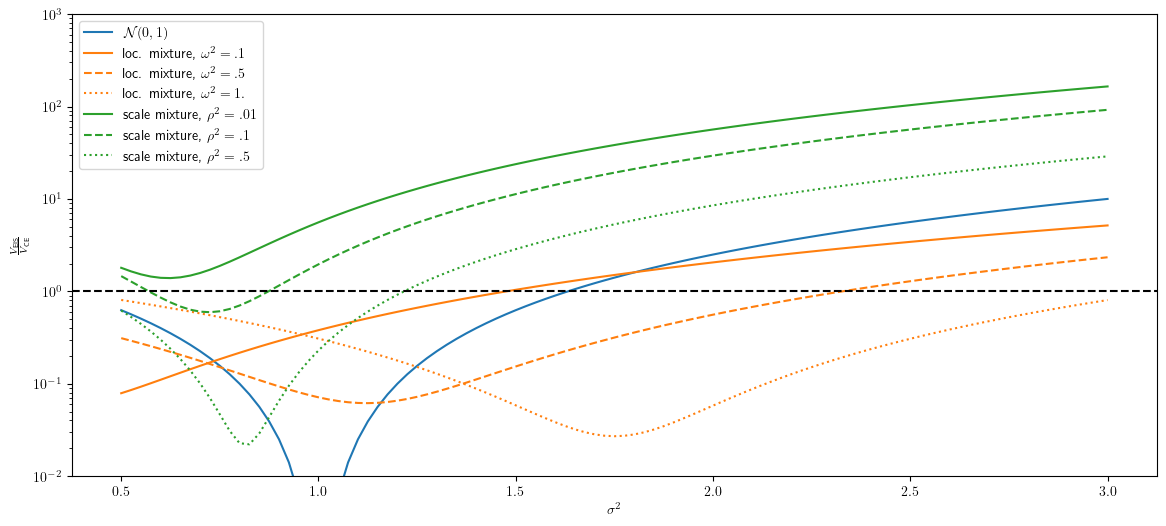

In [9]:
plt.plot(s2s, are_normal, label="$\\mathcal N (0,1)$", color=colors[0])
plt.plot(s2s, are_gmm[0], label="loc. mixture, $\\omega^2 = .1$", color=colors[1])
plt.plot(s2s, are_gmm[1], label="loc. mixture, $\\omega^2 = .5$", color=colors[1], linestyle="--")
plt.plot(s2s, are_gmm[2], label="loc. mixture, $\\omega^2 = 1.$", color=colors[1], linestyle=":")
plt.plot(s2s, are_gmm_scale[0], label="scale mixture, $\\rho^2 = .01$", color=colors[2])
plt.plot(s2s, are_gmm_scale[1], label="scale mixture, $\\rho^2 = .1$", color=colors[2], linestyle="--")
plt.plot(s2s, are_gmm_scale[2], label="scale mixture, $\\rho^2 = .5$", color=colors[2], linestyle=":")

plt.axhline(1., color="black", linestyle="--")

plt.ylabel("$\\tfrac{V_{\\text{EIS}}}{V_{\\text{CE}}}$")
plt.xlabel("$\\sigma^2$")

plt.yscale("log")
plt.ylim(10**-2, 10**3)

#tikzplotlib.clean_figure()
plt.legend()
tikzplotlib.save(
    "../tikz/are_mu.tex", 
    extra_axis_parameters={"legend style={nodes={scale=0.5, transform shape}}"}
)

## `tikz/are_sigma.tex`

In [10]:
V_eis_fun = lambdify((mu, tau), V_eis, "jax")
V_ce_fun = lambdify((mu, tau), V_ce, "jax")

def gmm_s2(mu, omega2, N, key, N_var):
    key, *keys = jrn.split(key, N_var + 1)
    keys = jnp.array(keys)

    P = MixtureSameFamily(
        mixture_distribution=Categorical(probs=jnp.array([.5, .5])),
        components_distribution=Normal(jnp.array([-1., 1.]), jnp.sqrt(omega2))
    )
    mixture_estimators = partial(s2_ce_eis, P=P)
    
    return vmap(mixture_estimators, (None, 0, None))(N, keys, mu)

def gmm_scale_s2(mu, rho2, N, key, N_var):
    key, *keys = jrn.split(key, N_var + 1)
    keys = jnp.array(keys)

    P = MixtureSameFamily(
        mixture_distribution=Categorical(probs=jnp.array([.5, .5])),
        components_distribution=Normal(jnp.array([0., 0.]), jnp.array([1., jnp.sqrt(rho2)]))
    )
    mixture_estimators = partial(s2_ce_eis, P=P)
    
    return vmap(mixture_estimators, (None, 0, None))(N, keys, mu)

def gmm_are_s2(mu, omega2, N, key, N_var):
    var_ce, var_eis = (gmm_s2(mu, omega2, N, key, N_var)).var(axis=0)
    return var_eis/var_ce

def gmm_scale_are_s2(mu, rho2, N, key, N_var):
    var_ce, var_eis = (gmm_scale_s2(mu, rho2, N, key, N_var)).var(axis=0)
    return var_eis/var_ce

veis = vmap(V_eis_fun, (0, None))(mus, 1.)
vce = vmap(V_ce_fun, (0, None))(mus, 1.)
are_normal = veis/vce

key, subkey = jrn.split(key)
are_gmm = vmap(
    vmap(gmm_are_s2, (0, None, None, None, None)),
    (None, 0, None, None, None) 
)(mus, omega2s, int(1e4), subkey, 100)
are_gmm_scale = vmap(
    vmap(gmm_scale_are_s2, (0, None, None, None, None)),
    (None, 0, None, None, None)
)(mus, rho2s, int(1e4), subkey, 100)

In [11]:
df_est_mu = pd.DataFrame({
    "mu": mus,
    "normal": are_normal,
    "GMM_omega.1": are_gmm[0],
    "GMM_omega.5": are_gmm[1],
    "GMM_omega1": are_gmm[2],
    "GMM_scale_rho.01": are_gmm_scale[0],
    "GMM_scale_rho.1": are_gmm_scale[1],
    "GMM_scale_rho.5": are_gmm_scale[2]
})

df_est_mu.to_csv("../data/figures/are_sigma2.csv", index=False)

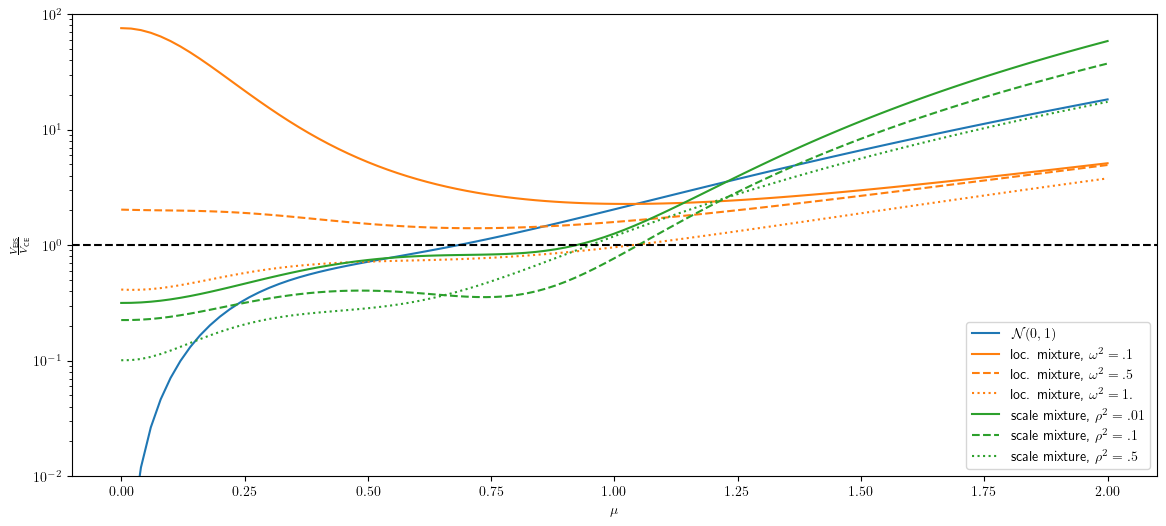

In [12]:
plt.plot(mus, are_normal, label="$\\mathcal N (0,1)$", color=colors[0])
plt.plot(mus, are_gmm[0], label="loc. mixture, $\\omega^2 = .1$", color=colors[1])
plt.plot(mus, are_gmm[1], label="loc. mixture, $\\omega^2 = .5$", color=colors[1], linestyle="--")
plt.plot(mus, are_gmm[2], label="loc. mixture, $\\omega^2 = 1.$", color=colors[1], linestyle=":")
plt.plot(mus, are_gmm_scale[0], label="scale mixture, $\\rho^2 = .01$", color=colors[2])
plt.plot(mus, are_gmm_scale[1], label="scale mixture, $\\rho^2 = .1$", color=colors[2], linestyle="--")
plt.plot(mus, are_gmm_scale[2], label="scale mixture, $\\rho^2 = .5$", color=colors[2], linestyle=":")
plt.axhline(1., color="black", linestyle="--")
plt.ylabel("$\\frac{V_{\\text{EIS}}}{V_{\\text{CE}}}$")
plt.xlabel("$\\mu$")
plt.ylim(10**-2, 10**2)
plt.yscale("log")

plt.legend()
tikzplotlib.save("../tikz/are_sigma.tex")
plt.show()

## `tikz/rho_mu_ce.tex`


In [13]:
vv_gmm_s2 = vmap(vmap(gmm_s2, (0, None, None, None, None)), (None, 0, None, None, None))
vv_gmm_scale_s2 = vmap(vmap(gmm_scale_s2, (0, None, None, None, None)), (None, 0, None, None, None))

psi_ces = jnp.array([
    -1/2/(tau2 + mus**2), # normal
    *vv_gmm_s2(mus, omega2s,1000, subkey, 100).mean(axis=-2)[:,:,0], # loc. mixture
    *vv_gmm_scale_s2(mus, rho2s,1000, subkey, 100).mean(axis=-2)[:,:,0] # scale mixture
])

#sigma2_normal_ces = -1/2/psi_ces
#rho_ce_normal = vmap(jnp_rho_normal, (None, None, 0,0))(0., 1., mus, jnp.sqrt(sigma2_normal_ces))


#rho_gmm = vmap(
#    vmap(jnp_rho_gmm, (None, None, 0,0)),
#    (None, 0, None, None)
#)(0., 1., mus, jnp.sqrt(sigma2_normal_ces))

sigma_ces = jnp.sqrt(-1/2/psi_ces)
rho_ces = jnp.array([
    vmap(jnp_rho_normal, (None,None, 0,0))(0., tau2, mus, sigma_ces[0]),
    vmap(jnp_rho_gmm, (None, None, 0,0))(0., omega2s[0], mus, sigma_ces[1]),
    vmap(jnp_rho_gmm, (None, None, 0,0))(0., omega2s[1], mus, sigma_ces[2]),
    vmap(jnp_rho_gmm, (None, None, 0,0))(0., omega2s[2], mus, sigma_ces[3]),
    vmap(jnp_rho_gmm, (None, None, 0,0))(0., omega2s[0], mus, sigma_ces[4]),
    vmap(jnp_rho_gmm, (None, None, 0,0))(0., omega2s[1], mus, sigma_ces[5]),
    vmap(jnp_rho_gmm, (None, None, 0,0))(0., omega2s[2], mus, sigma_ces[6]),
])

In [14]:
psi_eiss = jnp.array([
    -1/2/(tau2 + 2*mus**2), # normal
    *vv_gmm_s2(mus, omega2s,1000, subkey, 100).mean(axis=-2)[:,:,1], # loc. mixture
    *vv_gmm_scale_s2(mus, rho2s,1000, subkey, 100).mean(axis=-2)[:,:,1] # scale mixture
])

sigma_eiss = jnp.sqrt(-1/2/psi_eiss)
rho_eiss = jnp.array([
    vmap(jnp_rho_normal, (None,None, 0,0))(0., tau2, mus, sigma_eiss[0]),
    vmap(jnp_rho_gmm, (None, None, 0,0))(0., omega2s[0], mus, sigma_eiss[1]),
    vmap(jnp_rho_gmm, (None, None, 0,0))(0., omega2s[1], mus, sigma_eiss[2]),
    vmap(jnp_rho_gmm, (None, None, 0,0))(0., omega2s[2], mus, sigma_eiss[3]),
    vmap(jnp_rho_gmm, (None, None, 0,0))(0., omega2s[0], mus, sigma_eiss[4]),
    vmap(jnp_rho_gmm, (None, None, 0,0))(0., omega2s[1], mus, sigma_eiss[5]),
    vmap(jnp_rho_gmm, (None, None, 0,0))(0., omega2s[2], mus, sigma_eiss[6]),
])

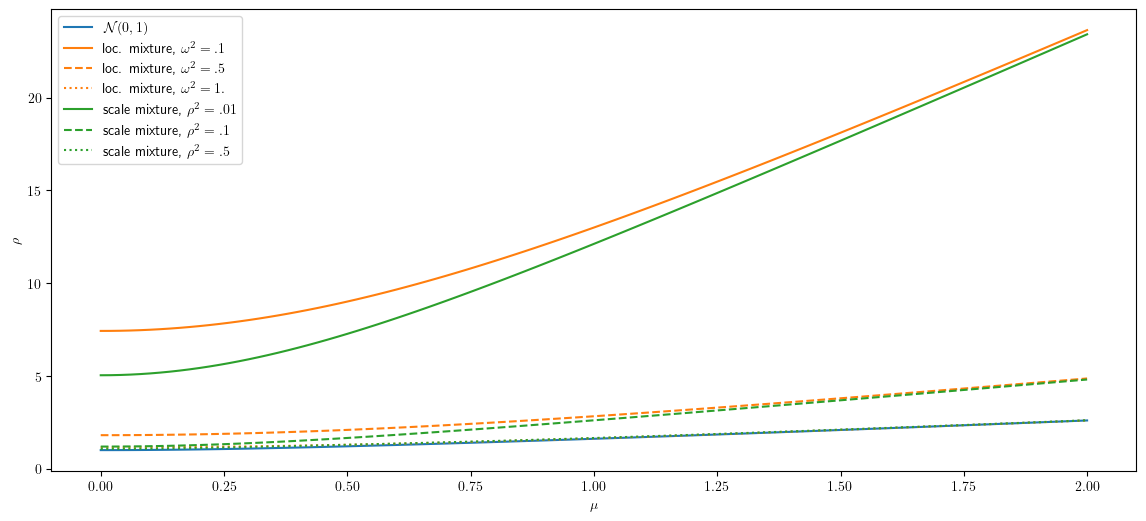

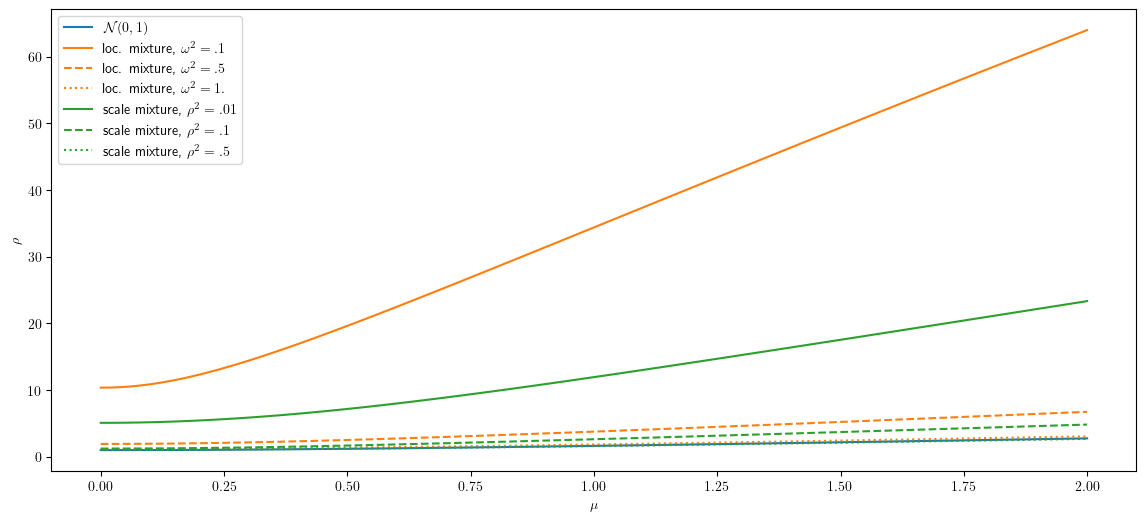

In [15]:
plt.plot(mus, rho_ces[0], label="$\\mathcal N (0,1)$", color=colors[0])
plt.plot(mus, rho_ces[1], label="loc. mixture, $\\omega^2 = .1$", color=colors[1])
plt.plot(mus, rho_ces[2], label="loc. mixture, $\\omega^2 = .5$", color=colors[1], linestyle="--")
plt.plot(mus, rho_ces[3], label="loc. mixture, $\\omega^2 = 1.$", color=colors[1], linestyle=":")
plt.plot(mus, rho_ces[4], label="scale mixture, $\\rho^2 = .01$", color=colors[2])
plt.plot(mus, rho_ces[5], label="scale mixture, $\\rho^2 = .1$", color=colors[2], linestyle="--")
plt.plot(mus, rho_ces[6], label="scale mixture, $\\rho^2 = .5$", color=colors[2], linestyle=":")

plt.ylabel("$\\rho$")
plt.xlabel("$\\mu$")
#plt.ylim(10**-2, 10**2)
#plt.yscale("log")

plt.legend()
#tikzplotlib.save("../tikz/are_mu.tex")
plt.show()
plt.plot(mus, rho_eiss[0], label="$\\mathcal N (0,1)$", color=colors[0])
plt.plot(mus, rho_eiss[1], label="loc. mixture, $\\omega^2 = .1$", color=colors[1])
plt.plot(mus, rho_eiss[2], label="loc. mixture, $\\omega^2 = .5$", color=colors[1], linestyle="--")
plt.plot(mus, rho_eiss[3], label="loc. mixture, $\\omega^2 = 1.$", color=colors[1], linestyle=":")
plt.plot(mus, rho_eiss[4], label="scale mixture, $\\rho^2 = .01$", color=colors[2])
plt.plot(mus, rho_eiss[5], label="scale mixture, $\\rho^2 = .1$", color=colors[2], linestyle="--")
plt.plot(mus, rho_eiss[6], label="scale mixture, $\\rho^2 = .5$", color=colors[2], linestyle=":")

plt.ylabel("$\\rho$")
plt.xlabel("$\\mu$")
#plt.ylim(10**-2, 10**2)
#plt.yscale("log")

plt.legend()
#tikzplotlib.save("../tikz/are_mu.tex")
plt.show()

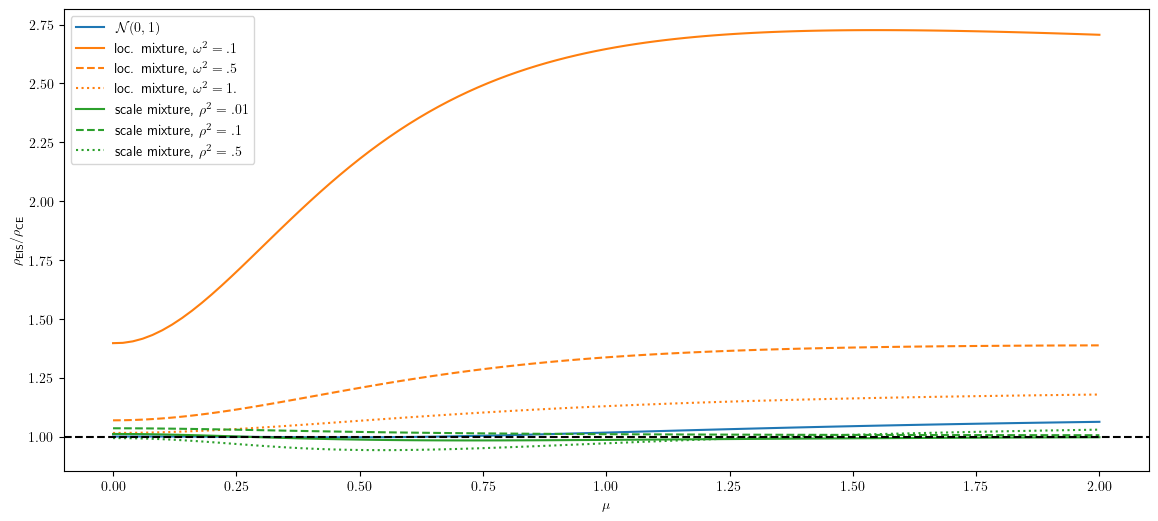

In [16]:
relative_rho = rho_eiss / rho_ces
plt.plot(mus, relative_rho[0], label="$\\mathcal N (0,1)$", color=colors[0])
plt.plot(mus, relative_rho[1], label="loc. mixture, $\\omega^2 = .1$", color=colors[1])
plt.plot(mus, relative_rho[2], label="loc. mixture, $\\omega^2 = .5$", color=colors[1], linestyle="--")
plt.plot(mus, relative_rho[3], label="loc. mixture, $\\omega^2 = 1.$", color=colors[1], linestyle=":")
plt.plot(mus, relative_rho[4], label="scale mixture, $\\rho^2 = .01$", color=colors[2])
plt.plot(mus, relative_rho[5], label="scale mixture, $\\rho^2 = .1$", color=colors[2], linestyle="--")
plt.plot(mus, relative_rho[6], label="scale mixture, $\\rho^2 = .5$", color=colors[2], linestyle=":")

plt.ylabel("$\\rho_{\\text{EIS}} / \\rho_{\\text{CE}}$")
plt.xlabel("$\\mu$")
plt.axhline(1., color="black", linestyle="--")
#plt.ylim(10**-2, 10**2)
#plt.yscale("log")

plt.legend()
#tikzplotlib.save("../tikz/are_mu.tex")
plt.show()

# Draft code

In [17]:
assert False
key = jrn.PRNGKey(10)
key ,*keys = jrn.split(key, 101)

keys = jnp.array(keys)

Ns = jnp.logspace(1, 5, 9).astype(int)

omega2 = 1.
s2 = 10000.

normal_estimators = partial(mu_ce_eis, P=Normal(0., jnp.sqrt(omega2)))

vars = jnp.array([
  (vmap(normal_estimators, (None, 0, None))(N, keys, s2)).var(axis=0)
  for N in Ns
])

coef_ce = jnp.polyfit(jnp.log(Ns), jnp.log(vars[:,0]), 1)
coef_eis = jnp.polyfit(jnp.log(Ns), jnp.log(vars[:,1]), 1)

plt.scatter(Ns, vars[:,0])
plt.scatter(Ns, vars[:,1])

plt.plot(Ns, jnp.exp(coef_ce[1]) * Ns ** coef_ce[0], label=f"CE: {coef_ce[0]:.2f}", alpha=.5)
plt.plot(Ns, jnp.exp(coef_eis[1]) * Ns ** coef_eis[0], label=f"EIS: {coef_eis[0]:.2f}", alpha=.5)

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

AssertionError: 

<IPython.core.display.Latex object>

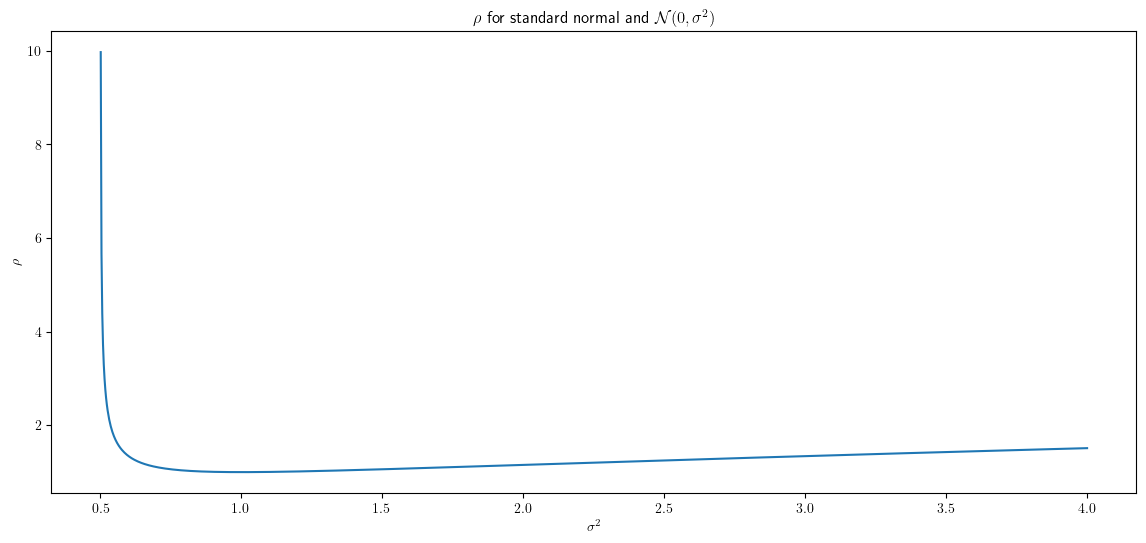

In [ ]:
# second moment of weights under G, for P = N(nu, tau**2), G = N(mu, sigma**2)
# int p^2/g
show("\\rho_{\\mathcal N(\\nu, \\tau^2), \\mathcal N(\\mu, \\sigma^2)}", rho_normal().simplify())

sigs =  jnp.linspace(.1, 2, 1001)
rhos = vmap(jnp_rho_normal, (None, None, None, 0))(0., 1., 0.,sigs)
plt.title("$\\rho$ for standard normal and $\\mathcal N (0, \\sigma^2)$")
plt.plot(sigs**2, rhos)
plt.ylabel("$\\rho$")
plt.xlabel("$\\sigma^2$")
plt.show()

$\providecommand{\G}{\mathbf G}$
Second moment of weights for $\P = \mathcal N (\nu, \tau^2)$, $\G = \mathcal N (\mu, \sigma^2)$

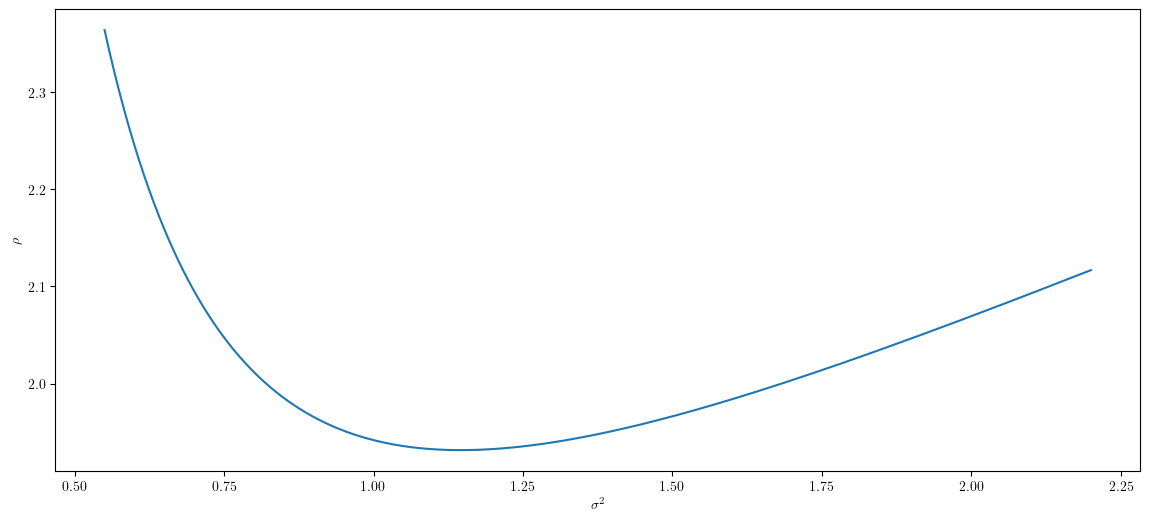

In [ ]:
omega2 = .1
P = MixtureSameFamily(
    mixture_distribution=Categorical(probs=jnp.array([.5, .5])),
    components_distribution=Normal(jnp.array([-1., 1.]), jnp.sqrt(omega2))
)
key, *keys = jrn.split(key, 101)
keys = jnp.array(keys)

-1/2/vmap(partial(s2_ce_eis, P=P), (None, 0, None))(int(1e4), keys, 0.).mean(axis=0)

tau2 = .1
sig2s =  jnp.linspace(1/2+tau2/2, 2+2*tau2, 1001)
rhos = vmap(jnp_rho_gmm, (None, None, None, 0))(-1., jnp.sqrt(tau2), 0.,jnp.sqrt(sig2s))
plt.plot(sig2s, rhos)
plt.xlabel("$\\sigma^2$")
plt.ylabel("$\\rho$")
plt.show()

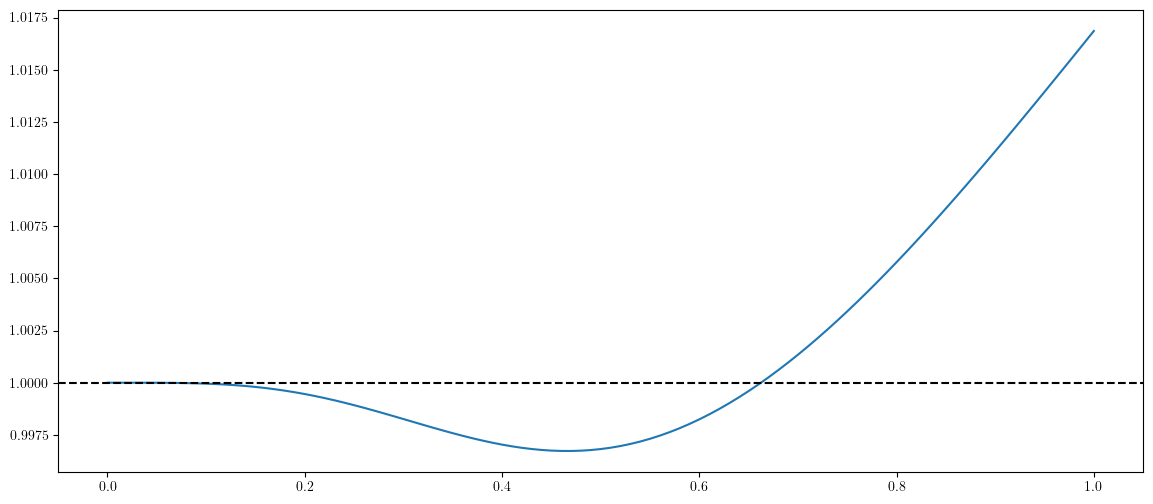

In [ ]:
sigma_ce_fun = lambdify((mu, tau), sqrt(-1/2/psie_ce_normal_variance), "jax")
sigma_eis_fun = lambdify((mu, tau), sqrt(-1/2/psi_eis_normal_variance), "jax")


mus = jnp.linspace(0, 1, 101)
sigma_ces = vmap(sigma_ce_fun, (0,None))(mus, 1.)
sigma_eiss = vmap(sigma_eis_fun, (0, None))(mus, 1.)
rho_ce = vmap(jnp_rho_normal, (None, None, 0,0))(0., 1., mus, sigma_ces)
rho_eis = vmap(jnp_rho_normal, (None, None, 0,0))(0., 1., mus, sigma_eiss)

plt.plot(mus, rho_eis/rho_ce)
plt.axhline(1., color="black", linestyle="--")
plt.show()